In [24]:
# GPU로 설정

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset

import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)

1.6.0+cu101


# Padding
- 일정한 크기의 층으로 이미지를 감싸는 것
- 즉, 이미지의 크기를 늘리는 것

# Pooling
- Convolution을 거쳐서 나온 activation maps이 있을 때, 이를 이루는 convolution layer을 resizing하여 새로운 layer를 얻는 것
- 즉, 크기 줄이는 것
- 종류 : MaxPooling, AveragePooling
  - MaxPooling: 강한 자극만 남기고 나머지 무시
  - AveragePooling: 평균적인 자극을 전달

In [26]:
batch_size = 256
learning_rate = 0.002
num_epoch = 10

In [27]:
mnist_train = dset.MNIST("./",train=True,transform = transforms.ToTensor(),target_transform=None,download=True)
mnist_test = dset.MNIST("./",train=False,transform = transforms.ToTensor(),target_transform=None,download=True)
# transform : 각각 데이터와 라벨에 대한 변형
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size = batch_size,shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size = batch_size,shuffle=True,num_workers=2,drop_last=True)
# batch_size만큼 묶고, num_workers = 묶을 때 사용할 프로세스 개수
# drop_last = 묶고 남는 데이터 버릴지 여부

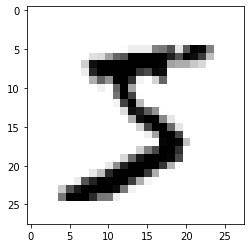

In [28]:
import matplotlib
some_digit_image = mnist_train.__getitem__(0)[0].reshape(28,28)
plt.imshow(some_digit_image,cmap = matplotlib.cm.binary,interpolation='nearest')

In [29]:
class CNN(nn.Module): # 상속받을 부모 클래스
  def __init__(self):
    super(CNN,self).__init__()
    self.layer = nn.Sequential(nn.Conv2d(1,16,5),
                               nn.ReLU(),
                               nn.Conv2d(16,32,5),
                               nn.ReLU(),
                               nn.MaxPool2d(2,2), # maxpooling 
                               nn.Conv2d(32,64,5),
                               nn.ReLU(),
                               nn.MaxPool2d(2,2))
    self.fc_layer = nn.Sequential(
        nn.Linear(64*3*3,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )
  def forward(self,x):
    out = self.layer(x)
    out = out.view(batch_size,-1)
    out = self.fc_layer(out)
    return out

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [32]:
loss_arr =[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j % 1000 == 0:
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.2979, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0881, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0242, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0185, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward>)


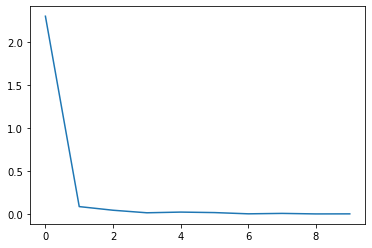

In [33]:
plt.plot(loss_arr)
plt.show()

In [35]:
correct = 0
total = 0
with torch.no_grad():
  for image,label in test_loader:
    x = image.to(device)
    y_ = label.to(device)

    output = model.forward(x)
    _,output_index = torch.max(output,1)

    total += label.size(0)
    correct += (output_index == y_).sum().float()
print('Accuracy of Test Data: {}'.format(100*correct/total))

Accuracy of Test Data: 99.00841522216797
